In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d

pd.set_option("display.max_columns", None)
from tqdm import tqdm
tqdm.pandas()

In [2]:
import_folder_path = rf"..\..\Datasets\Europe"

# DATA WRANGLING

In [3]:
testing = pd.read_spss(rf"{import_folder_path}/Risikoatlas_EuropeanSurvey_translated_allcountries.sav")

In [4]:
df00 = pd.read_excel(rf"{import_folder_path}/RisikoAtlas_EuropeanSurvey.xlsx", skiprows = 1)

In [5]:
# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df00["age"] = df00["s2_1"].astype(float)

# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df00["gender_text"] = np.where( df00["s1"] == 1, "Female", "Male")
df00["income"] = df00["incomelevels"].astype(float).fillna(0)
df00["wealth"] = df00["q14_1"].astype(float).fillna(-1)

df00["country"] = df00["country"].astype(float)
df00["country_text"] = np.where(df00["country"] == 12, "France",
                                np.where(df00["country"] == 21, "Poland",
                                         np.where(df00["country"] == 9, "UK",
                                                  np.where(df00["country"] == 10, "Spain",
                                                           np.where(df00["country"] == 29, "Sweden",
                                                                    np.where(df00["country"] == 7, "Germany", "None",
                                                                            )
                                                                   )
                                                          )
                                                 )
                                        )
                               )

df00["income"] = df00["income"].astype(float)
df00["income_text"] = np.where(df00["income"] == 1, "Below 15,000 GPB",
                                np.where(df00["income"] == 2, "15,000 - 24,999 GBP",
                                         np.where(df00["income"] == 3, "25,000 – 34,999 GBP",
                                                  np.where(df00["income"] == 4, "35,000 – 44,999 GBP",
                                                           np.where(df00["income"] == 5, "45,000 – 60,000 GBP",
                                                                    np.where(df00["income"] == 6, "More than 60,000 GBP", 
                                                                             np.where(df00["income"] == 0, "None", "NA"
                                                                                     )
                                                                            )
                                                                   )
                                                          )
                                                 )
                                        )
                               )

In [6]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

# print("Total Observations:", df00["Q1"].count())

print(f'\nGender:\n{remove_indexname(df00["gender_text"].value_counts())}')
print('-' * 100)
print(f'ISCED:\n{remove_indexname(df00["isced"].value_counts().sort_index())}')
print('-' * 100)
print(f'Income:\n{remove_indexname(df00["income_text"].value_counts().sort_index())}')
print(f'\nIncome_code:\n{remove_indexname(df00["income"].value_counts().sort_index())}')
print('-' * 100)
print(f'Countries:\n{remove_indexname(df00["country_text"].value_counts())}')
print(f'\nCountries_code:\n{remove_indexname(df00["country"].value_counts())}')
print('-' * 100)



# print(f'\nOccupation:\n{remove_indexname(df0["Q4a"].value_counts())}')
# print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts())}')


Gender:
Female    2000
Male      1906
----------------------------------------------------------------------------------------------------
ISCED:
1    1197
2    1795
3     914
----------------------------------------------------------------------------------------------------
Income:
15,000 - 24,999 GBP     785
25,000 – 34,999 GBP     654
35,000 – 44,999 GBP     480
45,000 – 60,000 GBP     359
Below 15,000 GPB        853
More than 60,000 GBP    240
None                    535

Income_code:
0.0    535
1.0    853
2.0    785
3.0    654
4.0    480
5.0    359
6.0    240
----------------------------------------------------------------------------------------------------
Countries:
France     677
Poland     656
UK         652
Spain      646
Sweden     643
Germany    632

Countries_code:
12.0    677
21.0    656
9.0     652
10.0    646
29.0    643
7.0     632
----------------------------------------------------------------------------------------------------


## NO WEALTH WINSORIZATION

In [7]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

def winsorize_output(sample, variable, limits = [0, 0]):
    sample[f"nonwinsorised_{variable}"] = sample[variable]
    sample[f"winsorised_{variable}"] = winsorize(np.array(sample[f"nonwinsorised_{variable}"]), limits = limits, inclusive = [False, False])
    sample[[f"nonwinsorised_{variable}", f"winsorised_{variable}"]].describe()
    print(sample[[f"winsorised_{variable}", f"nonwinsorised_{variable}"]].describe())
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    sns.kdeplot(data = sample[f"nonwinsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[0])
    axes[0].set_title(f'Nonwinsorised {variable}')
    sns.kdeplot(data = sample[f"winsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[1])
    axes[1].set_title(f'Winsorized {variable}')
    plt.tight_layout()
    plt.show()

    sample[variable] = sample[f"winsorised_{variable}"]
    return sample[variable]

       winsorised_wealth  nonwinsorised_wealth
count       3.906000e+03          3.906000e+03
mean        1.278176e+05          1.278176e+05
std         4.128250e+05          4.128250e+05
min        -1.000000e+00         -1.000000e+00
25%        -1.000000e+00         -1.000000e+00
50%         1.500000e+00          1.500000e+00
75%         5.000000e+04          5.000000e+04
max         5.000000e+06          5.000000e+06


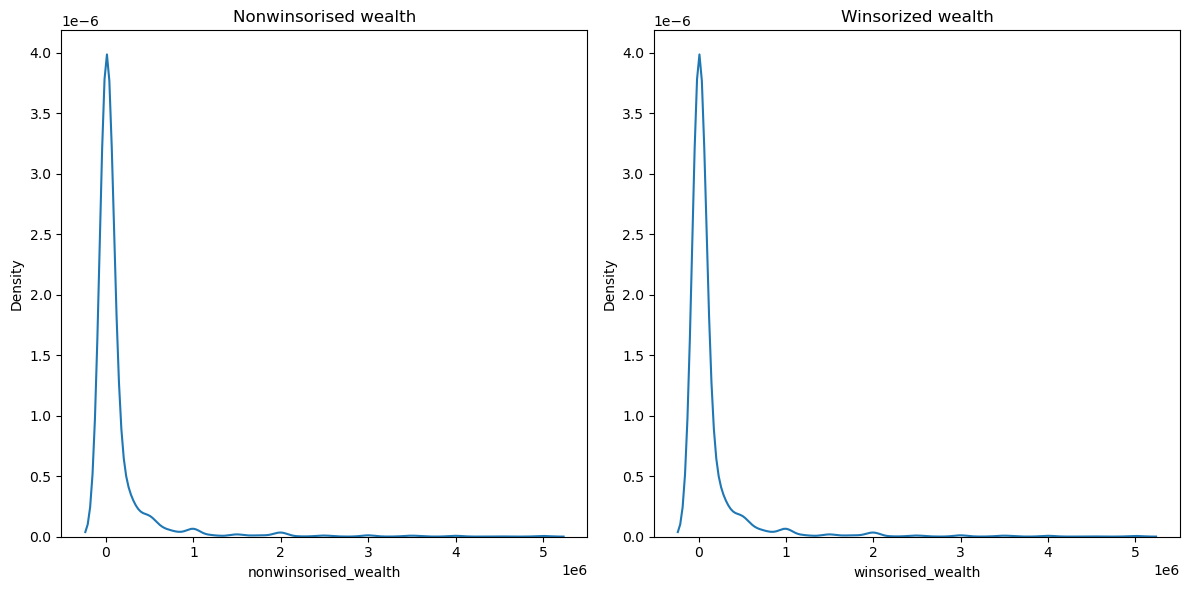

In [8]:
winsorized_wealth = winsorize_output(df00, "wealth", [0, 0])

In [9]:
# Using winsorised wealth as wealth
df00["wealth"] = winsorized_wealth

## SCORING

In [10]:
focal_col = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5",
             "q8_3", "q8_4",
             "q8_5berlin_1", "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7",
             "q9_1_1", "q9_2_1", "q9_3",
             "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]

for col in focal_col:
    df00[col] = df00[col].astype(float)

scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5",
"uncertainty1", "uncertainty2",
"numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5",
"graph1", "graph2", "graph3",
"riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5",
"bayesian1"
]


df00[scoreColumns] = 0

In [11]:
df00

,responseid,status,country,leg_conditions_riskp,q0,s1,s2_1,age_rec,s5uk,s4de,s5de,s4it,s5it,s4es,s5es,s5fr,s5pl,s5se,isced,s7,s8,English_occupation,q5_1,q5_2,q5_5,q5_6,q5_9,q8_2_1,q8_2_2,q8_2_3,q8_2_4,q8_2_5,q8_3,q8_4,q8_5berlin_1,q8_5london_1,q8_5paris_1,q8_6,q8_7,q9_1_1,q9_2_1,q9_3,q10_1_1,q10_2_1,q10_3_1,q10_4,q11_1,q12,q13_1,q13_2,q13_3,q13_4,q13_5,q13_4_other,English_otherinsur,q14_1,q14_na,q15_1,q16,q17,weight,reflectivespending,higherincomegroup,financialproductclear,ignore_dist6,Understanding1,Understanding2,Understanding3,Understanding4,Understanding5,graphunderstanding1,graphunderstanding2,graphunderstanding3,Calculating1,Calculating2,Calculating3,Calculating4,Certainty2,Certainty3,Certainty4,Certainty5,Uncertainty1,Uncertainty2,highriskliterate,lowriskliterate,mediumriskliterate,rl_sumscore,incomelevels,emergencyfund,isced_recoded,age,gender_text,income,wealth,country_text,income_text,nonwinsorised_wealth,winsorised_wealth,certainty1,certainty2,certainty3,certainty4,certainty5,uncertainty1,uncertainty2,numeracy1,numeracy2,numeracy3,numeracy4,numeracy5,graph1,graph2,graph3,riskcomprehension1,riskcomprehension2,riskcomprehension3,riskcomprehension4,riskcomprehension5,bayesian1
0,2624,complete,10.0,2,1,1,65,4,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,2,Vilasantar,capataz,NaN,4,2,3,4,4,1.0,1.0,1.0,2.0,2.0,4.0,1.0,1.0,1.0,2.0,2.0,4.0,25.0,60.0,4.0,80.0,1.0,10.0,2.0,2,2,1,1,1,0,0,NaN,NaN,30000.0,0,6,3,1,0.503211,1,0.0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,2.0,1,1,65.0,Female,2.0,30000.0,Spain,"15,000 - 24,999 GBP",30000.0,30000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,296,complete,10.0,1,1,2,66,4,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,2,Alcala de Henares,Pensionista,NaN,4,3,1,5,4,1.0,1.0,1.0,2.0,2.0,4.0,4.0,1.0,1.0,2.0,3.0,2.0,25.0,20.0,3.0,650.0,10.0,0.1,3.0,2,2,0,1,1,1,0,auto,car,15000.0,0,2,1,3,0.503211,0,0.0,1,1,0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,1,0,1,0,4,2.0,1,1,66.0,Male,2.0,15000.0,Spain,"15,000 - 24,999 GBP",15000.0,15000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2666,complete,10.0,1,1,1,61,4,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,2,LA CORUÑA,JUBILADO,NaN,3,3,3,5,1,2.0,2.0,2.0,1.0,2.0,1.0,4.0,2.0,1.0,2.0,4.0,4.0,50.0,66.0,4.0,500.0,10.0,10.0,2.0,0,2,1,1,1,0,0,NaN,NaN,24000.0,0,0,1,4,0.503211,0,0.0,1,1,1,1,0,0,1,0,0,0,1,1,0,0,1,1,1,0,1,1,0,1,0,7,2.0,0,1,61.0,Female,2.0,24000.0,Spain,"15,000 - 24,999 GBP",24000.0,24000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2891,complete,10.0,2,1,2,60,4,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,2,valencia,visitador medico,NaN,5,3,2,5,5,1.0,1.0,1.0,1.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,25.0,20.0,3.0,500.0,10.0,0.1,3.0,0,3,1,1,0,0,0,NaN,NaN,200000.0,0,1,3,3,0.503211,0,0.0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,8,3.0,1,1,60.0,Male,3.0,200000.0,Spain,"25,000 – 34,999 GBP",200000.0,200000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2633,complete,10.0,3,1,1,74,4,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,2,Barcelona,Jubilada,NaN,5,5,5,5,2,1.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,25.0,60.0,1.0,60.0,10.0,1.0,3.0,1,2,1,0,1,1,0,Coche,car,200.0,0,1,2,1,0.503211,1,0.0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2,2.0,1,1,74.0,Female,2.0,200.0,Spain,"15,000 - 24,999 GBP",200.0,200.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,1764,complete,10.0,2,1,2,32,2,NaN,NaN,NaN,NaN,NaN,2.0,6.0,NaN,NaN,NaN,3,AVILA,Parado,NaN,3,3,3,3,5,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,4.0,4.0,2.0,36.0,4.0,12.0,34.0,34.0,3.0,4,7,0,0,0,0,1,NaN,NaN,NaN,1,5,1,1,1.345079,1,NaN,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [12]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [13]:
df01 = df00.groupby(["responseid"]).progress_apply(scoring1)
df01 = df01.reset_index(drop = True).copy()

100%|████████████████████████████████████████████████████████████████████████████▉| 3903/3906 [00:29<00:00, 120.58it/s]C:\Users\SHIVAM\anaconda3\Lib\site-packages\tqdm\std.py:805: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|█████████████████████████████████████████████████████████████████████████████| 3906/3906 [00:31<00:00, 123.19it/s]


In [14]:
def scoring2(survey):
    
    survey["Certainty_5"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_3"] = survey["numeracy1"] + survey["numeracy2"] + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_19"] = survey["Certainty_5"] + survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_3"] + survey["Bayesianreasoning_1"]
    
    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_3"] / 3 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_19"] / 19 * 100
    
    
    colReq = ["responseid", "country_text", "age", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
              "TotalScore_19", "TotalScore_%",]
    
    survey1 = survey[colReq].copy()
    return survey1

In [15]:
df02 = scoring2(df01)

In [16]:
euro = df02.copy()

In [17]:
# will be used later
wealth_quartile = pd.qcut(euro.loc[~ (euro["wealth"]==-1)]["wealth"],q = 4, labels = False, duplicates = "raise" )

## Income Terciles and Quartiles

How to Form Terciles from Categorical Data
If your categorical data has a natural order (ordinal data), you can divide it into terciles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Tercile Groups
The first tercile includes categories up to the point where the cumulative percentage reaches or exceeds 33.3%.
The second tercile includes categories up to the point where the cumulative percentage reaches or exceeds 66.7%.
The third tercile includes the remaining categories.
5. A single Tercile muct never exceed 50% of the sample. If a Tercile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Tercile.

In [18]:
income_filtered = euro[ ~(euro["income"] == 0)].copy()
income_filtered["income"].value_counts().sort_index() / len(income_filtered) * 100

income
1.0    25.304064
2.0    23.286858
3.0    19.400771
4.0    14.239098
5.0    10.649659
6.0     7.119549
Name: count, dtype: float64

### Income Terciles
1 - income = 1 2 --> 48 (25.304064 + 23.286858)

2 - income = 2 3 --> 33 (19.400771 + 14.239098)

3 - income = 4 5 6 --> 18 (10.649659 + 7.119549)

In [19]:
euro["income_tercile"] = np.where(euro["income"] == 1, 1,
                                  np.where(euro["income"] == 2, 1,
                                           np.where(euro["income"] == 3, 2,
                                                    np.where(euro["income"] == 4, 2,
                                                             np.where(euro["income"] == 5, 3,
                                                                      np.where(euro["income"] == 6, 3, -1
                                                                              )
                                                                     )
                                                            )
                                                   )
                                          )
                                 )                                  

### Income Quartiles
1 - income = 1 --> 27.7 (27.7)

2 - income = 2 --> 31.6 (31.6)

3 - income = 3 4 --> 27.1 (16.3 + 10.8)

4 - income = 5 6 --> 13.4 (7.4 + 6.0)

In [20]:
# euro["income_quartile"] = np.where(euro["income"] == 1, 1,
#                                    np.where(euro["income"] == 2, 2,
#                                            np.where(euro["income"] == 3, 3,
#                                                     np.where(euro["income"] == 4, 3,
#                                                              np.where(euro["income"] == 5, 4,
#                                                                       np.where(euro["income"] == 6, 4, -1
#                                                                                )
#                                                                       )
#                                                              )
#                                                     )
#                                            )
#                                    )   

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

In [21]:
#Global Vras:
facet_cols = ["Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1"]

facet_percent_cols = ["Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%",
                      "Numeracy_%", "Bayesianreasoning_%",]

# Study 2 - Europe

## Table 1.1 - Per country: Mean Total Score + SD

Text(0, 0.5, 'Mean Total score')

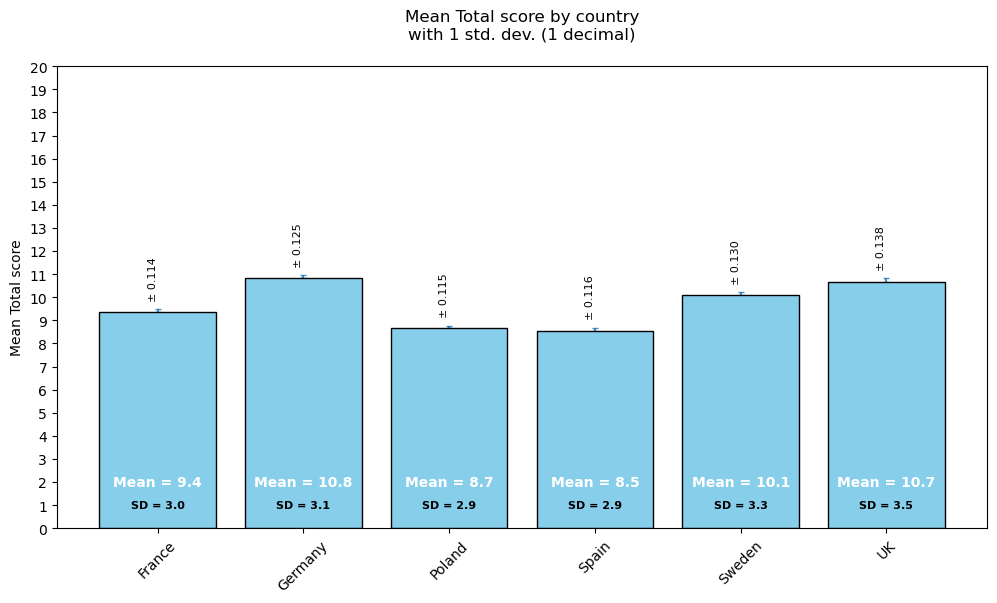

In [22]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

mean_scores = euro.groupby("country_text")["TotalScore_19"].mean().sort_index()
std_scores = euro.groupby("country_text")["TotalScore_19"].std().reindex(mean_scores.index)
sem_scores = euro.groupby("country_text")["TotalScore_19"].sem().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
                     fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 21))
axes.tick_params(axis = "x", rotation = 45)

for i, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(i, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(i, 2, f"Mean = {mean:.1f}", ha = "center", va = "center",
              color='white', fontsize=10, fontweight='bold')
    axes.text(i, 1, f"SD = {std:.1f}", ha = "center", va = "center",
              color='black', fontsize=8, fontweight='bold')
    

axes.set_title("Mean Total score by country\nwith 1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel("Mean Total score")

----------------------------------

## Table 1.2 - Per country: Mean Facet Scores + SD (Ver. 1)

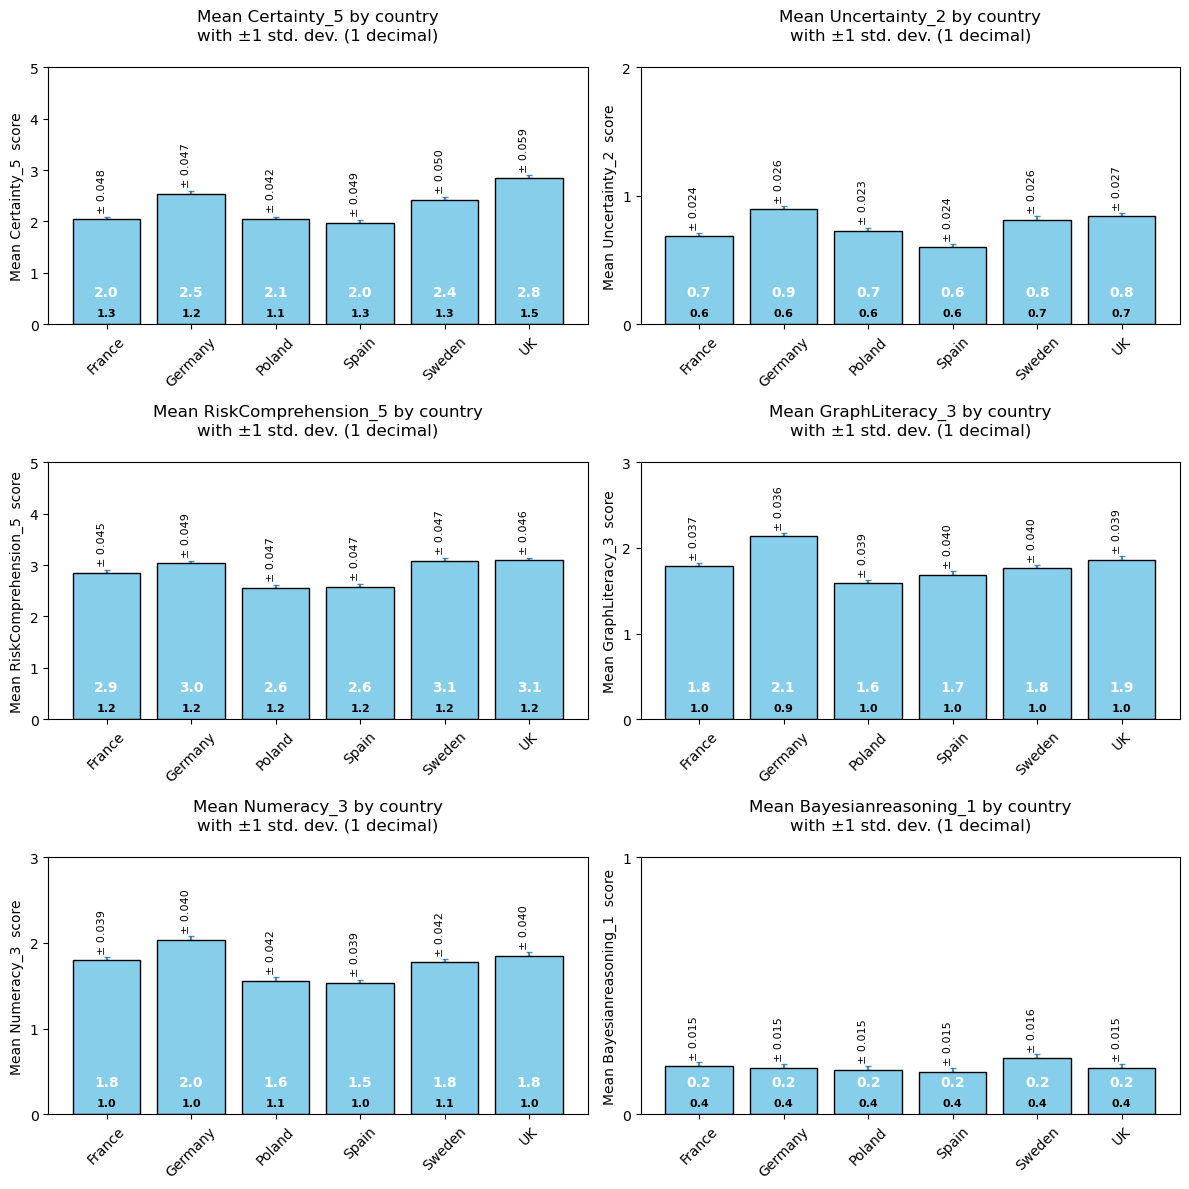

In [23]:
fig, axes = plt.subplots(3, 2, figsize = [12, 12])
axes = axes.flatten()

for i, facet in enumerate(facet_cols):
    mean_scores = euro.groupby("country_text")[facet].mean().sort_index()
    std_scores = euro.groupby("country_text")[facet].std().reindex(mean_scores.index)
    sem_scores = euro.groupby("country_text")[facet].sem().reindex(mean_scores.index)
    
    axes[i].bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
    axes[i].errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
                     fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

    y_max = int(facet.split("_")[1])
    axes[i].set_yticks(np.arange(0, y_max + 1))
    axes[i].tick_params(axis = "x", rotation = 45)
    
    for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
        axes[i].text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
        axes[i].text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
                     color='white', fontsize=10, fontweight='bold')
        axes[i].text(j, 0.025 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=8, fontweight='bold')

        
    
    axes[i].set_title(f"Mean {facet} by country\nwith ±1 std. dev. (1 decimal)", pad = 20)
    axes[i].set_ylabel(f"Mean {facet}  score")


plt.tight_layout()
plt.show()

## Table 1.2 - Per country: Mean Facet Scores + SD (Ver. 2)

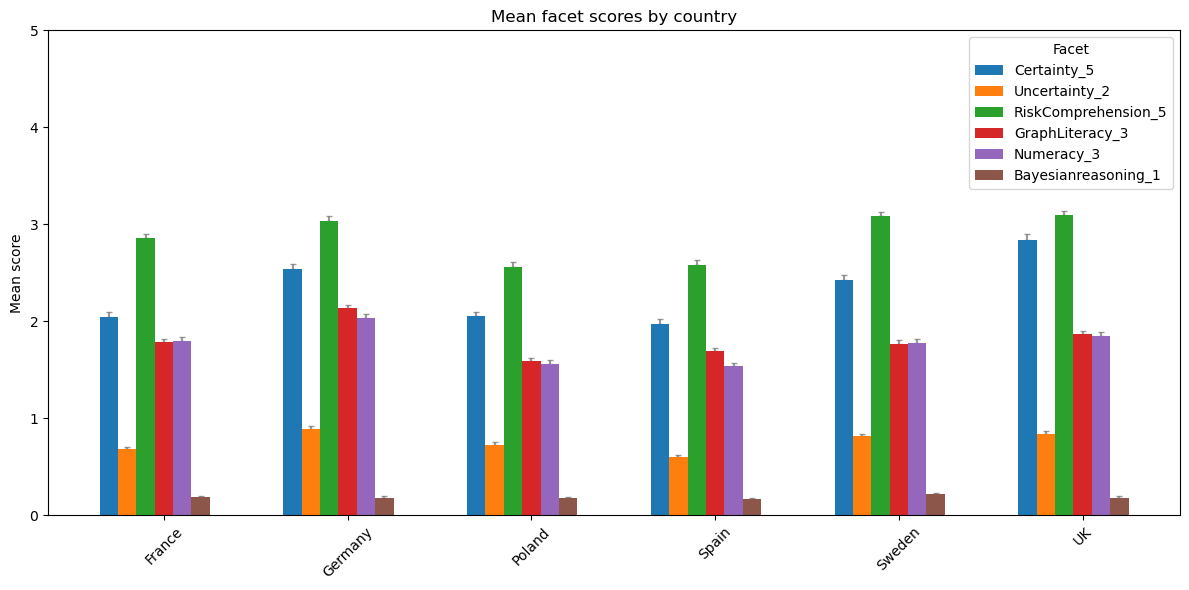

In [24]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

data_mean = euro.groupby("country_text")[facet_cols].mean().sort_index()
data_std = euro.groupby("country_text")[facet_cols].std().reindex(data_mean.index)
data_sem = euro.groupby("country_text")[facet_cols].sem().reindex(data_mean.index)

countries = data_mean.index
x = np.arange(1, len(data_mean.index) + 1)
width = 0.1

for i, facet in enumerate(facet_cols):
    mean_facet_scores = data_mean[facet]
    sem_facet_scores = data_sem[facet]

    offset = (- len(facet_cols)/ 2 + i) * width
    axes.bar(x + offset , mean_facet_scores, width, label = facet)
    axes.errorbar(x + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")

axes.set_yticks(np.arange(6))
axes.set_xticks(x)
axes.set_xticklabels(countries, rotation = 45, ha = "center")

axes.set_ylabel("Mean score")
axes.set_title("Mean facet scores by country")
axes.legend(title="Facet", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()



---

---

## Table 1.3 - Per country: M proportion of maximum (Total Score) score + SD + Median

Text(0, 0.5, 'Mean % Total score')

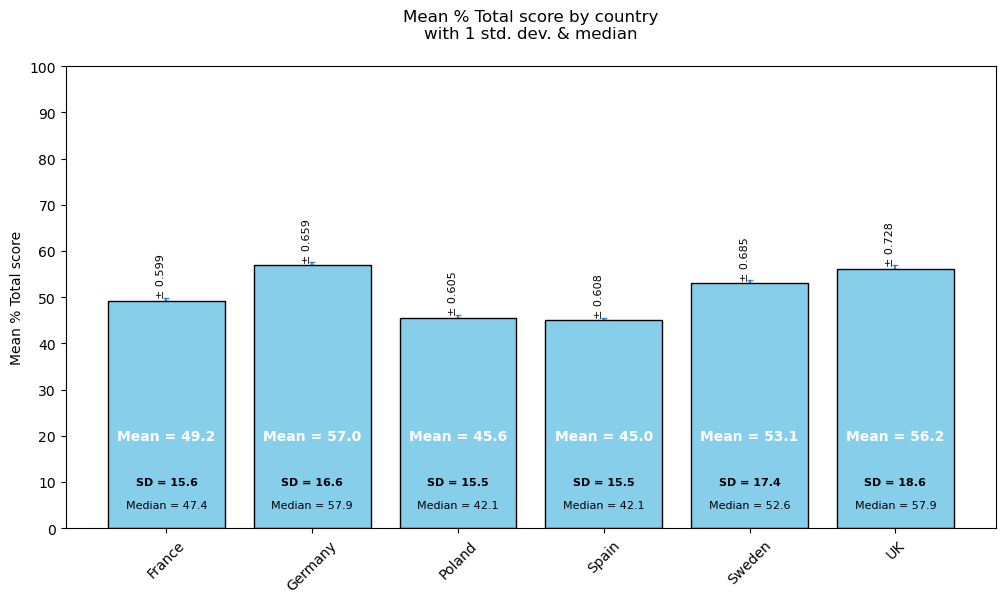

In [25]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

mean_scores = euro.groupby("country_text")["TotalScore_%"].mean().sort_index()
std_scores = euro.groupby("country_text")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores = euro.groupby("country_text")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores = euro.groupby("country_text")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
                     fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for i, (mean, std, sem, med) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values, med_scores.values)):
    axes.text(i, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(i, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
              color='white', fontsize=10, fontweight='bold')
    axes.text(i, 10, f"SD = {std:.1f}", ha = "center", va = "center",
              color='black', fontsize=8, fontweight='bold')
    axes.text(i, 5, f"Median = {med:.1f}", ha = "center", va = "center",
              color='black', fontsize=8)
    

axes.set_title("Mean % Total score by country\nwith 1 std. dev. & median", pad = 20)
axes.set_ylabel("Mean % Total score")

----------------------------------

## Table 1.4 - Per country: M proportion of Facet Scores + SD + Median (Ver. 1)

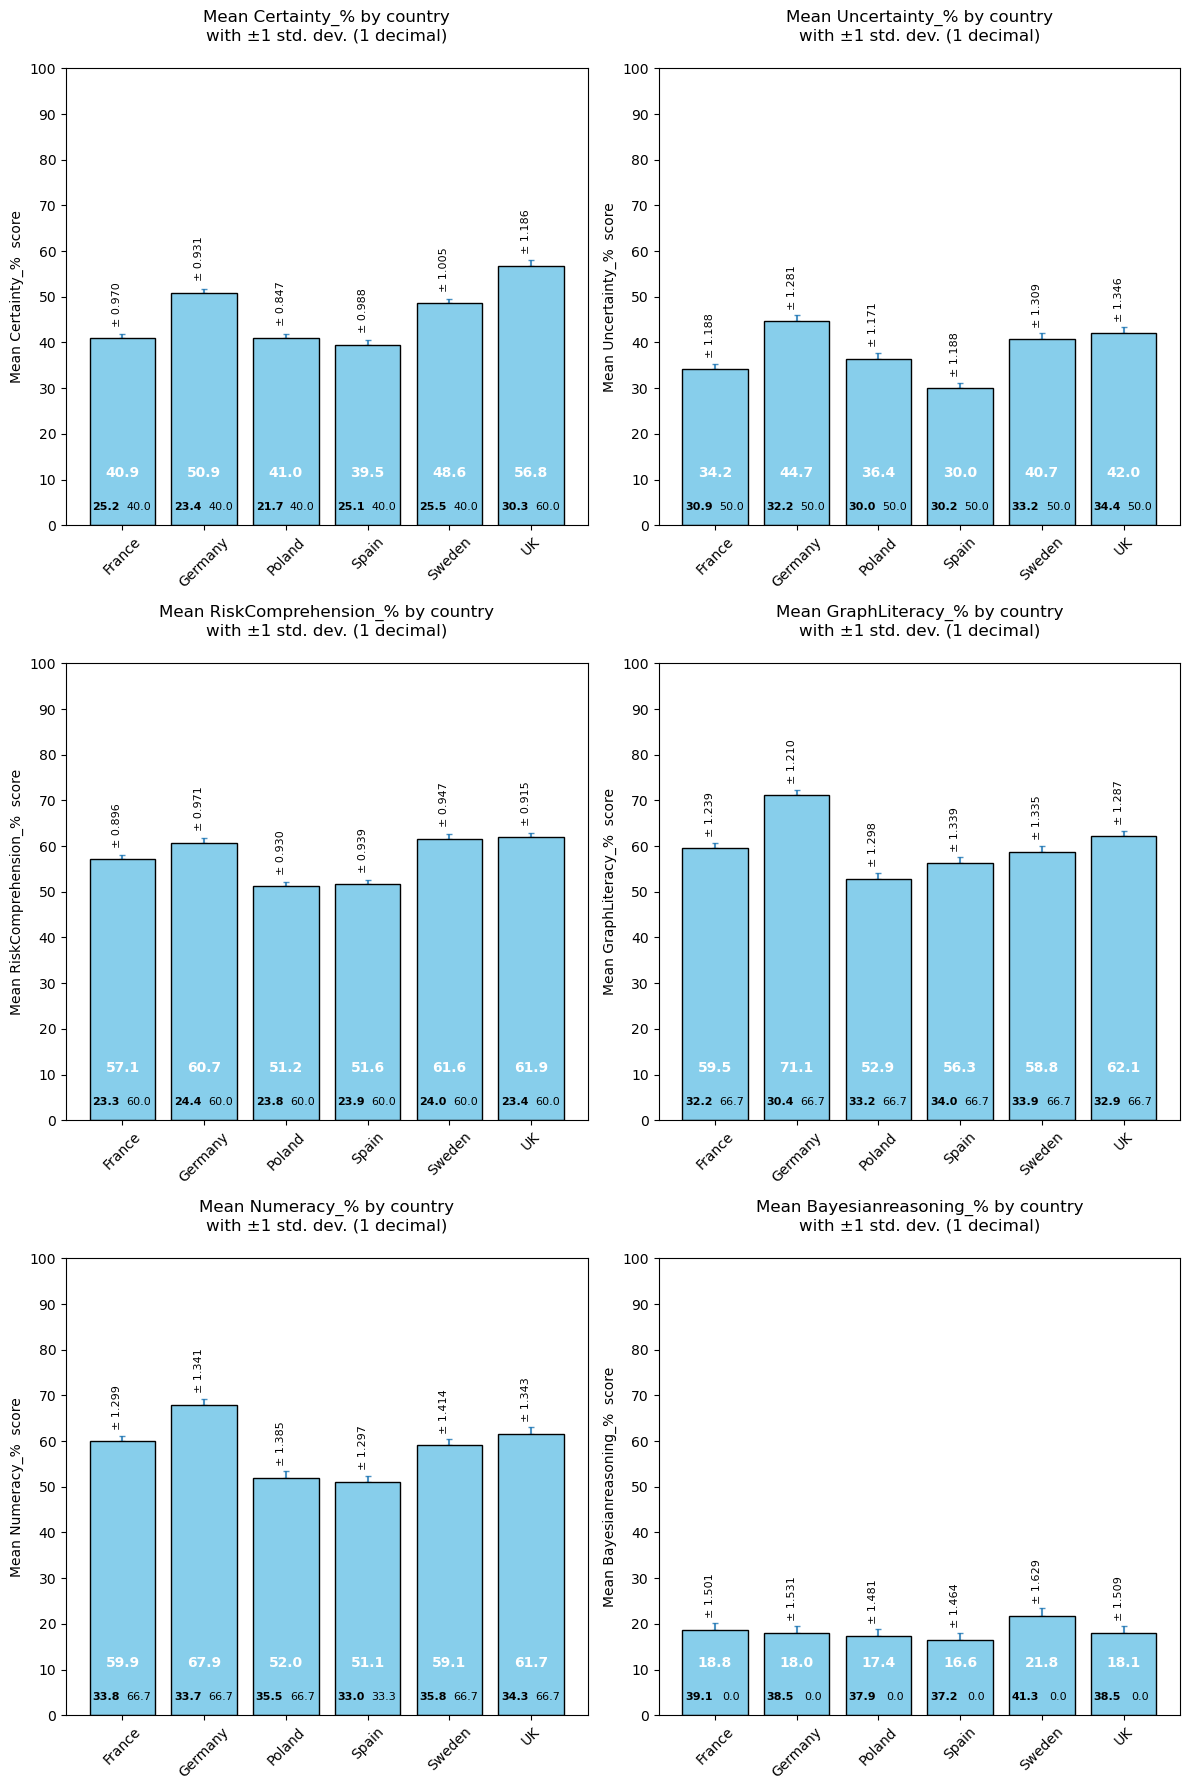

In [26]:
fig, axes = plt.subplots(3, 2, figsize = [12, 18])
axes = axes.flatten()

for i, facet in enumerate(facet_percent_cols):
    mean_scores = euro.groupby("country_text")[facet].mean().sort_index()
    std_scores = euro.groupby("country_text")[facet].std().reindex(mean_scores.index)
    sem_scores = euro.groupby("country_text")[facet].sem().reindex(mean_scores.index)
    med_scores = euro.groupby("country_text")[facet].median().reindex(mean_scores.index)
    
    axes[i].bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
    axes[i].errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
                     fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

    y_max = 100
    axes[i].set_yticks(np.arange(0, y_max + 1, step = 10))
    axes[i].tick_params(axis = "x", rotation = 45)
    
    for j, (mean, std, sem, med) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values, med_scores.values)):
        axes[i].text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
        axes[i].text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
                     color='white', fontsize=10, fontweight='bold')
        axes[i].text(j - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=8, fontweight='bold')
        axes[i].text(j + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=8)

        
    
    axes[i].set_title(f"Mean {facet} by country\nwith ±1 std. dev. (1 decimal)", pad = 20)
    axes[i].set_ylabel(f"Mean {facet}  score")


plt.tight_layout()
plt.show()

## Table 1.4 - Per country: M proportion of Facet Scores + SD + Median (Ver. 2)

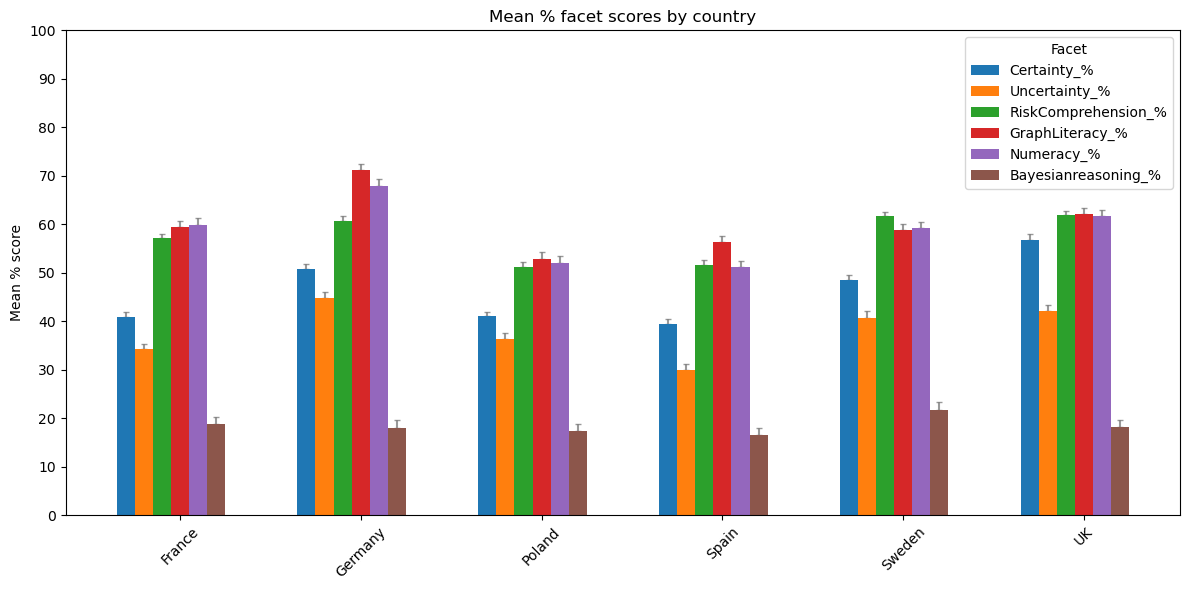

In [27]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

data_mean = euro.groupby("country_text")[facet_percent_cols].mean().sort_index()
data_std = euro.groupby("country_text")[facet_percent_cols].std().reindex(data_mean.index)
data_sem = euro.groupby("country_text")[facet_percent_cols].sem().reindex(data_mean.index)

countries = data_mean.index
x = np.arange(1, len(data_mean.index) + 1)
width = 0.1

for i, facet in enumerate(facet_percent_cols):
    mean_facet_scores = data_mean[facet]
    sem_facet_scores = data_sem[facet]

    offset = (- len(facet_cols)/ 2 + i) * width
    axes.bar(x + offset , mean_facet_scores, width, label = facet)
    axes.errorbar(x + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")

axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(x)
axes.set_xticklabels(countries, rotation = 45, ha = "center")

axes.set_ylabel("Mean % score")
axes.set_title("Mean % facet scores by country")
axes.legend(title="Facet", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()



---

---

## Table 2.1 - Per country per income class: M proportion of maximum score+SD + Median facet scores (Ver. 1)

Note: Income Class has been filtered out of entries who opted out of disclosing their income

In [28]:
income_filtered_euro = euro.loc[ ~(euro["income"] == 0)].copy()
income_filtered_euro.income.value_counts()

income
1.0    853
2.0    785
3.0    654
4.0    480
5.0    359
6.0    240
Name: count, dtype: int64

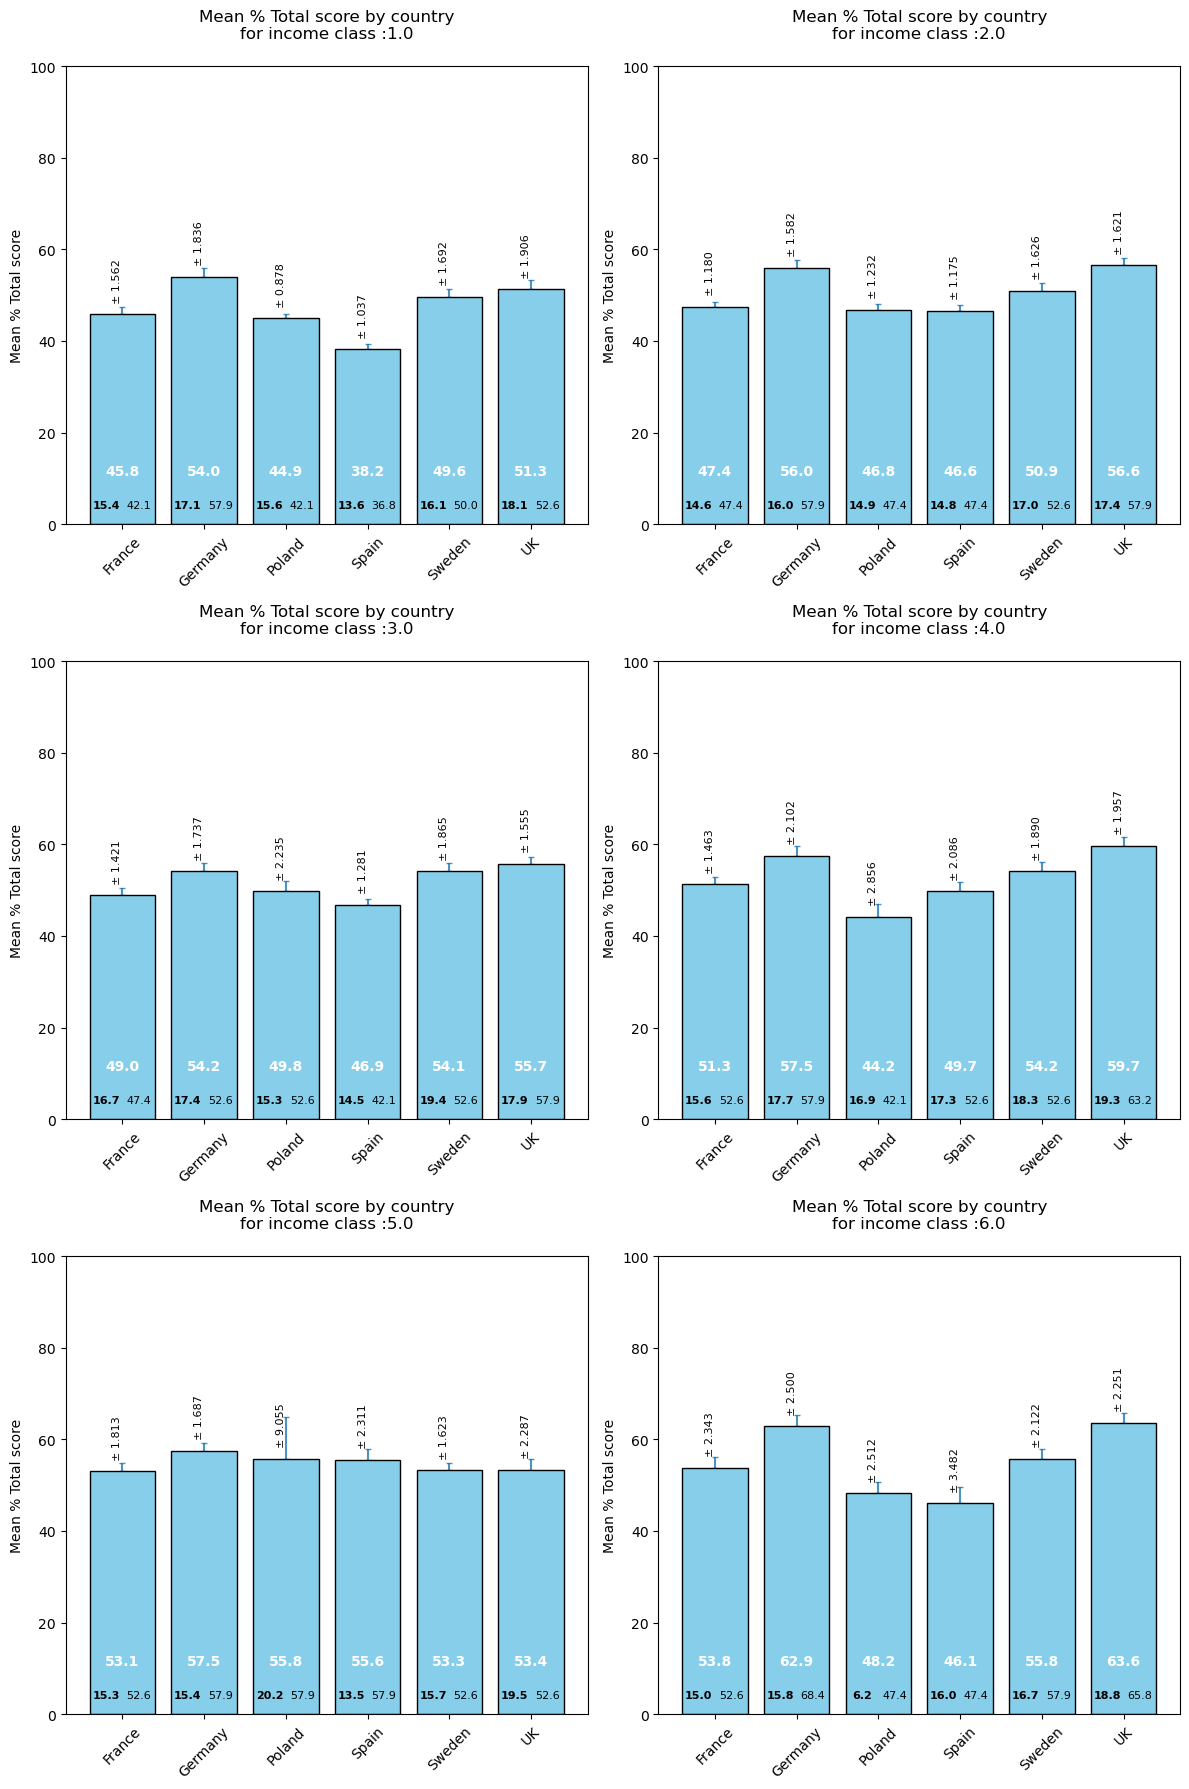

In [29]:
fig, axes = plt.subplots(3, 2, figsize = [12, 18])
axes = axes.flatten()
income_classes = income_filtered_euro.income.value_counts().sort_index().index.values

for i, income_class in enumerate(income_classes):
    sample = income_filtered_euro.loc[ income_filtered_euro["income"] == income_class].copy()
    
    mean_scores = sample.groupby("country_text")["TotalScore_%"].mean().sort_index()
    std_scores = sample.groupby("country_text")["TotalScore_%"].std().reindex(mean_scores.index)
    sem_scores = sample.groupby("country_text")["TotalScore_%"].sem().reindex(mean_scores.index)
    med_scores = sample.groupby("country_text")["TotalScore_%"].median().reindex(mean_scores.index)
    
    axes[i].bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
    axes[i].errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
                     fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

    y_max = 100
    axes[i].set_yticks(np.arange(0, 101, step = 20))
    axes[i].tick_params(axis = "x", rotation = 45)
    
    for j, (mean, std, sem, med) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values, med_scores.values)):
        axes[i].text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
        axes[i].text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
                     color='white', fontsize=10, fontweight='bold')
        axes[i].text(j - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=8, fontweight='bold')
        axes[i].text(j + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=8)
        
    
    axes[i].set_title(f"Mean % Total score by country\nfor income class :{income_class}", pad = 20)
    axes[i].set_ylabel("Mean % Total score")

plt.tight_layout()
plt.show()

---

## Table 2.1 - Per country per income class: M proportion of maximum score + SD + Median scores (Ver. 2)

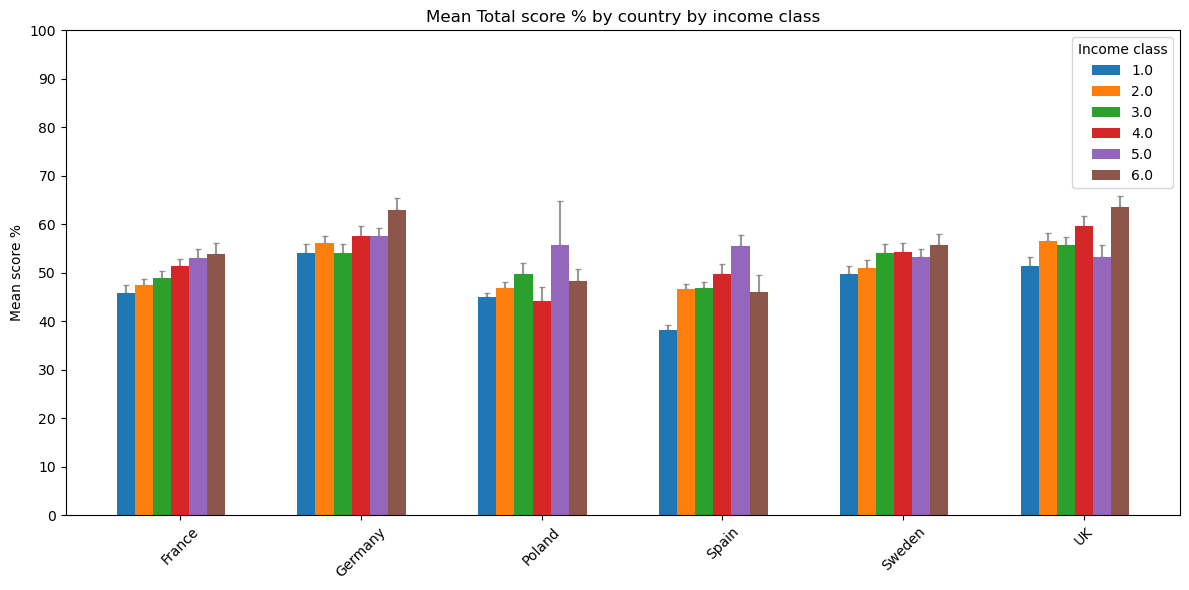

In [30]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])
income_classes = income_filtered_euro.income.value_counts().sort_index().index.values
sample = income_filtered_euro.copy().reset_index()


data_mean = sample.groupby(["country_text", "income"])["TotalScore_%"].mean().sort_index()
data_std = sample.groupby(["country_text", "income"])["TotalScore_%"].std().reindex(data_mean.index)
data_sem = sample.groupby(["country_text", "income"])["TotalScore_%"].sem().reindex(data_mean.index)

countries = sorted(sample["country_text"].unique())
x = np.arange(1, len(countries) + 1)
width = 0.1

for j, income_class in enumerate(income_classes):
    mean_facet_scores = data_mean.xs(key=income_class, level="income")
    sem_facet_scores = data_sem.xs(key=income_class, level="income")

    offset = (- len(income_classes)/ 2 + j) * width
    axes.bar(x + offset , mean_facet_scores, width, label = str(income_class))
    axes.errorbar(x + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(x)
axes.set_xticklabels(countries, rotation = 45, ha = "center")

axes.set_ylabel(f"Mean score %")
axes.set_title(f"Mean Total score % by country by income class")
axes.legend(title="Income class", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()


---

---

## Table 2.2 - Per country per income class: M proportion of facet score  +SD + Median

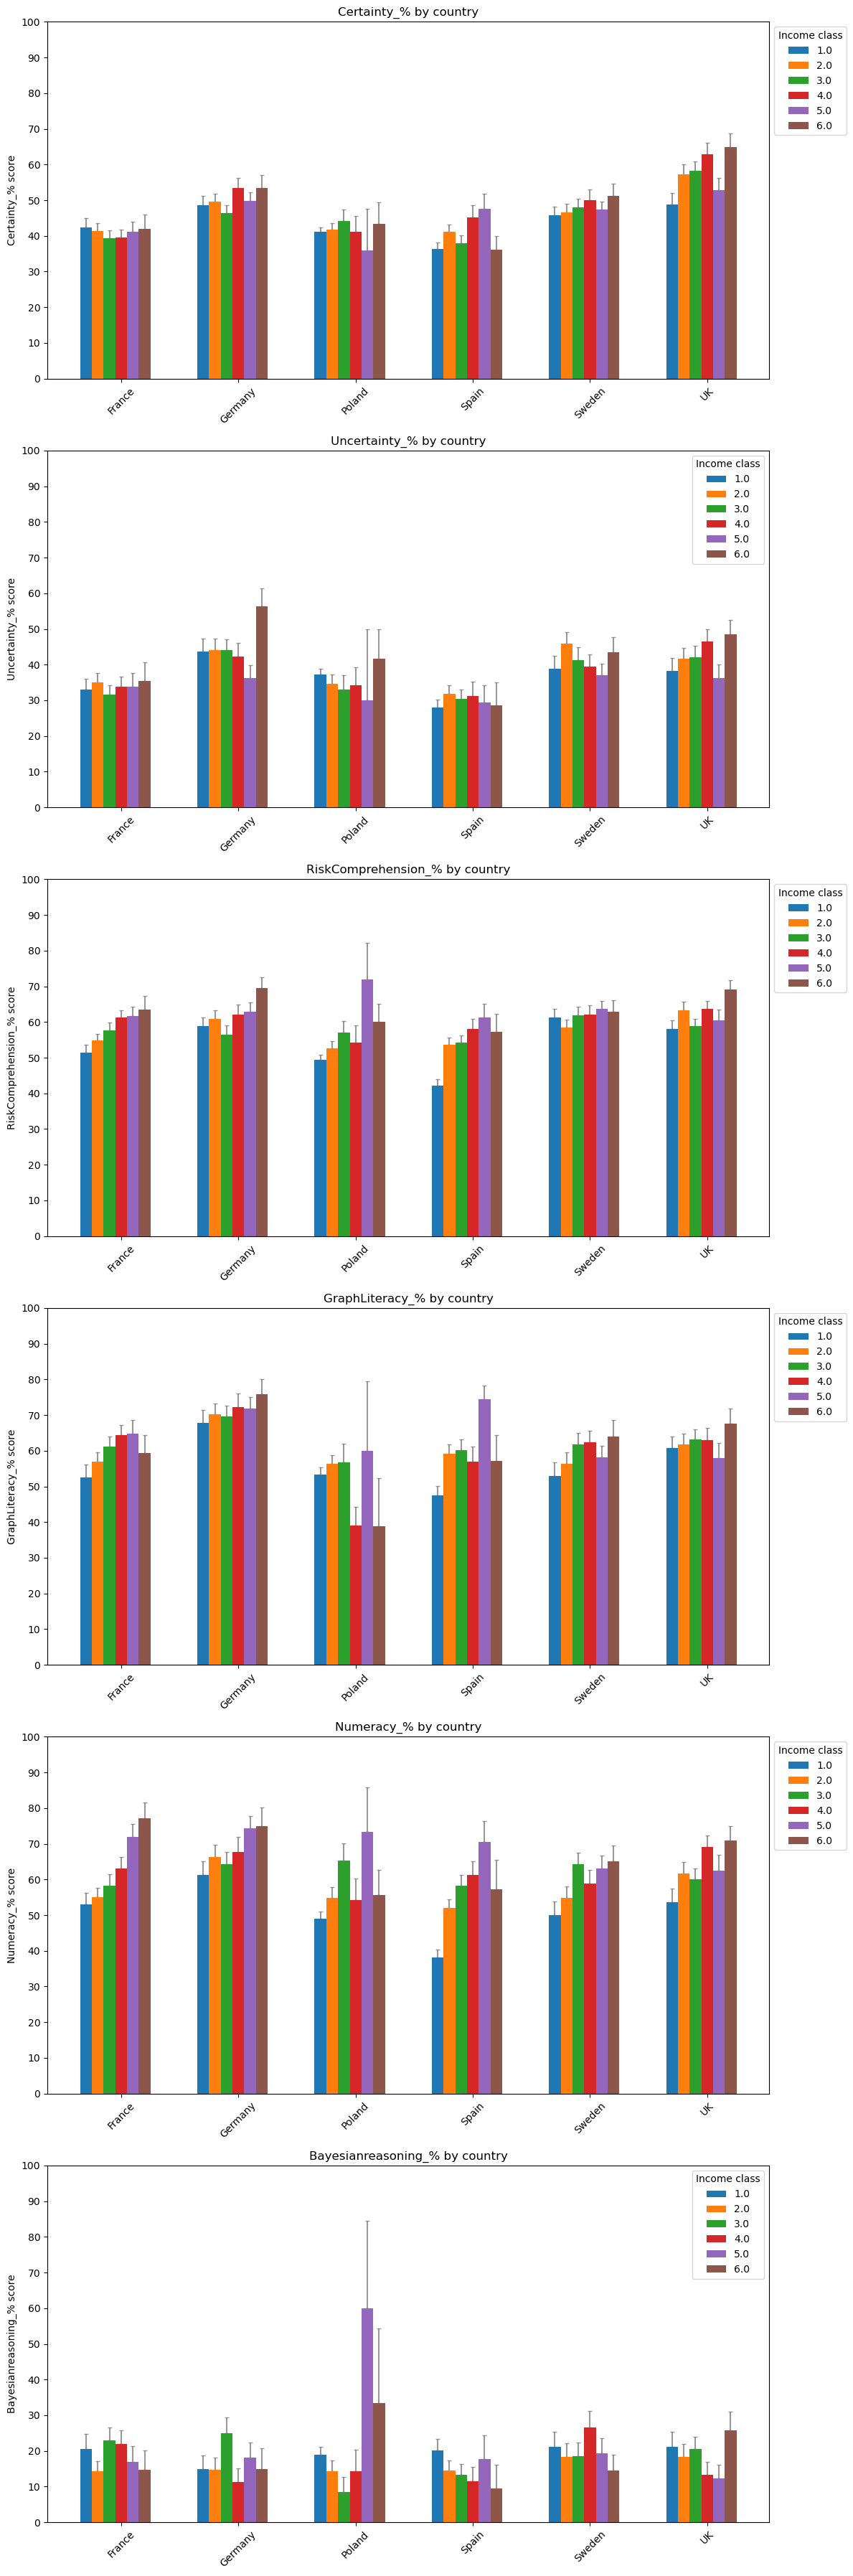

In [31]:
fig, axes = plt.subplots(6, 1, figsize = [12, 6*6])

axes = axes.flatten()
income_classes = income_filtered_euro.income.value_counts().sort_index().index.values

for i, facet in enumerate(facet_percent_cols):

    sample = income_filtered_euro.loc[ :, [facet] + ["country_text", "income"]].copy().reset_index()
    
    data_mean = sample.groupby(["country_text", "income"])[facet].mean().sort_index()
    data_std = sample.groupby(["country_text", "income"])[facet].std().reindex(data_mean.index)
    data_sem = sample.groupby(["country_text", "income"])[facet].sem().reindex(data_mean.index)
    
    countries = sorted(sample["country_text"].unique())
    x = np.arange(1, len(countries) + 1)
    width = 0.1
    
    for j, income_class in enumerate(income_classes):
        mean_facet_scores = data_mean.xs(key=income_class, level="income")
        sem_facet_scores = data_sem.xs(key=income_class, level="income")
    
        offset = (- len(income_classes)/ 2 + j) * width
        axes[i].bar(x + offset , mean_facet_scores, width, label = str(income_class))
        axes[i].errorbar(x + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                      fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")

    
    axes[i].set_yticks(np.arange(0, 101, step = 10))
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(countries, rotation = 45, ha = "center")
    
    axes[i].set_ylabel(f"{facet} score")
    axes[i].set_title(f"{facet} by country")
    axes[i].legend(title="Income class", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()



---

---

## Table 3.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [32]:
income_filtered_euro = euro.loc[ ~(euro["income"] == 0)].copy()

risklit_quartile = pd.qcut(income_filtered_euro["TotalScore_19"],q = 4, labels = False ) + 1
income_filtered_euro["risklit_quartile"] = risklit_quartile.copy()

data = income_filtered_euro.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [33]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "income")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
# plt.show()

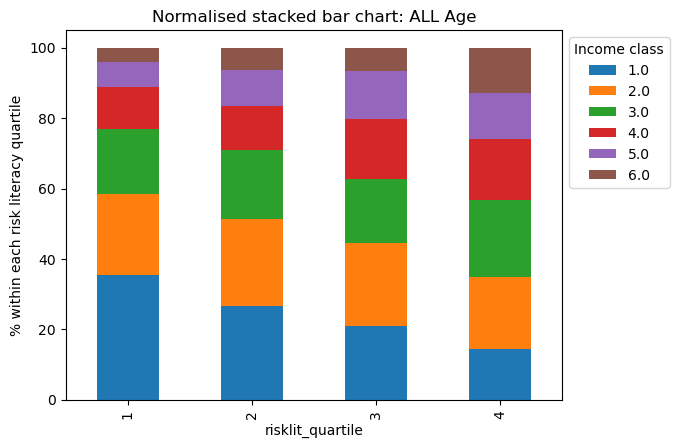

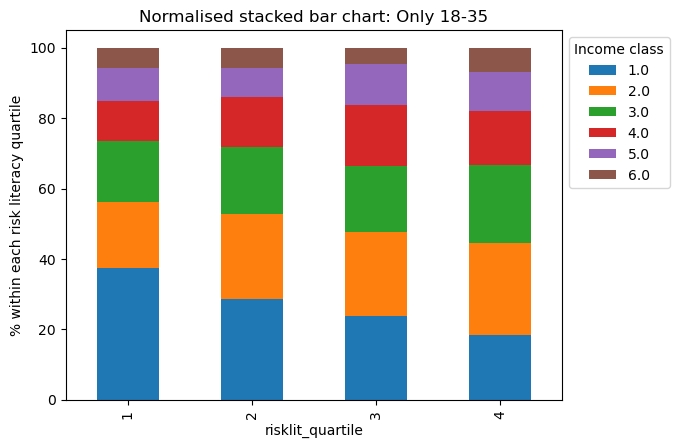

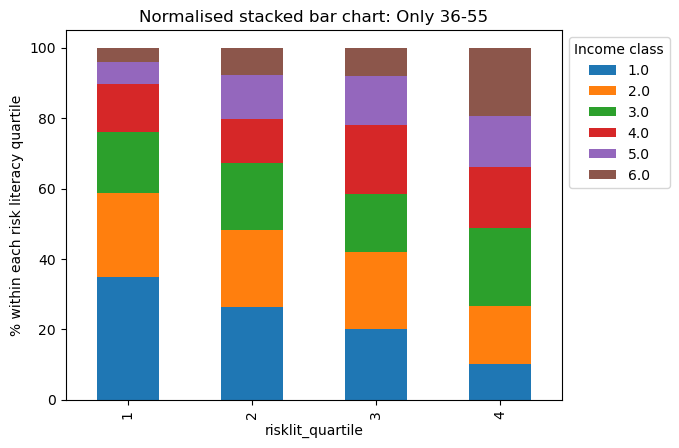

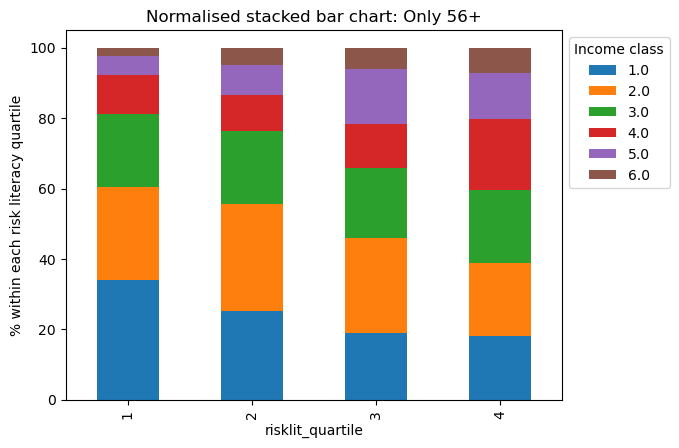

In [34]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "income")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

## Table 4.1 - Per country per wealth quartile: M proportion of maximum score + SD + Median scores (Ver. 1)

Note: Wealth Class has been filtered out of entries who opted out of disclosing their income, and a quartile on the resulting data has been created

In [35]:
wealth_filtered_euro = euro.loc[ ~(euro["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered_euro["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered_euro["wealth_quartile"] = wealth_quartile.copy()

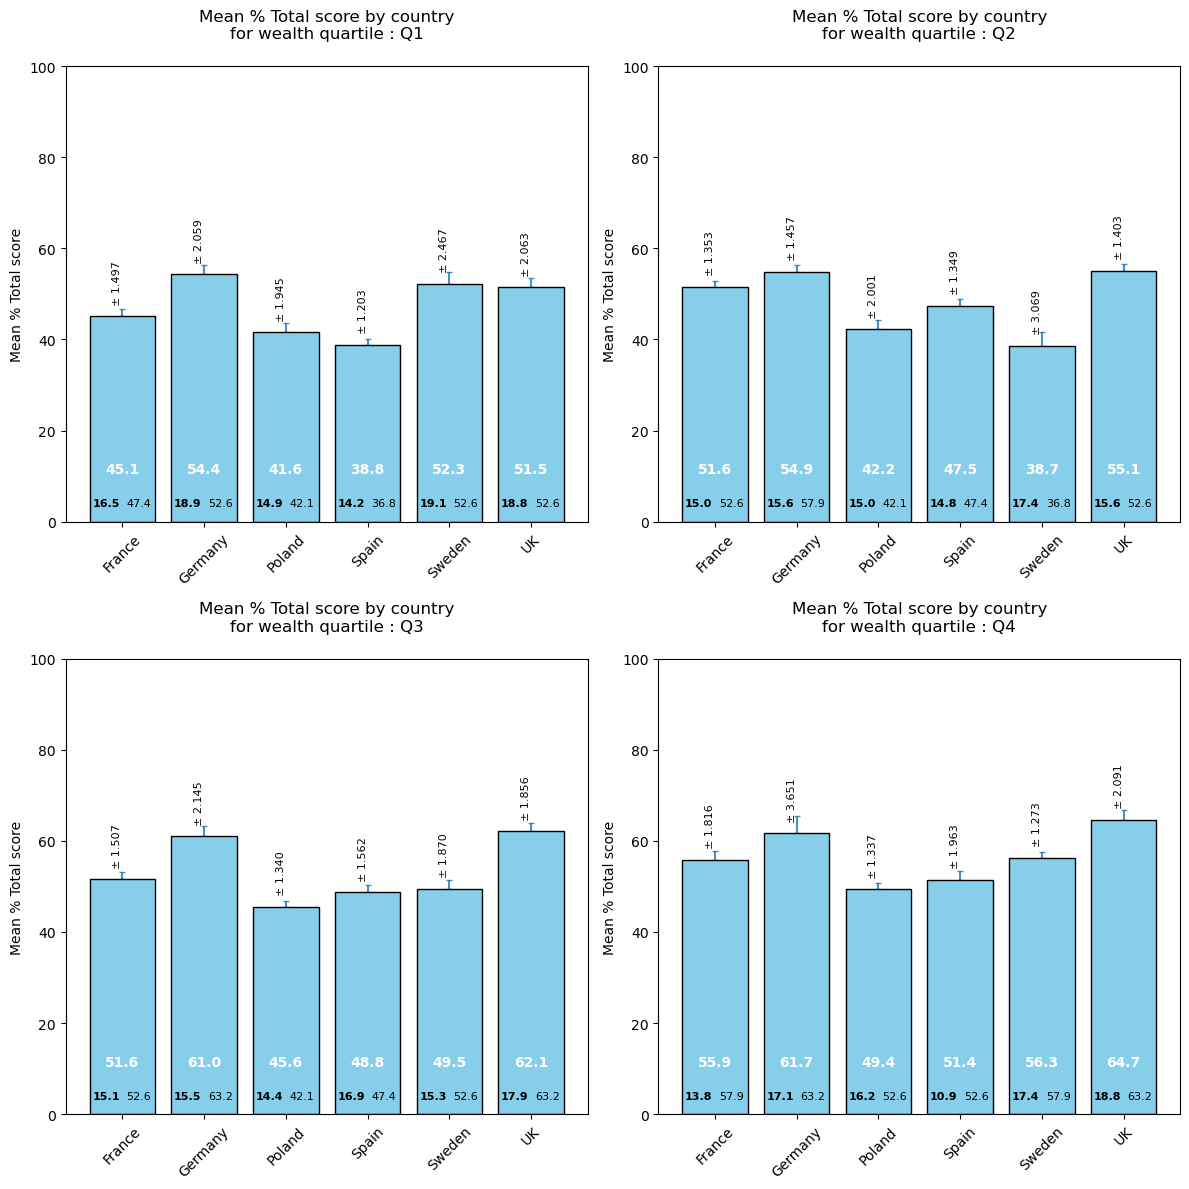

In [36]:
fig, axes = plt.subplots(2, 2, figsize = [12, 6*2])
axes = axes.flatten()
wealth_quartiles = sorted(wealth_filtered_euro["wealth_quartile"].unique())

for i, wealth_quartile in enumerate(wealth_quartiles):
    sample = wealth_filtered_euro.loc[ wealth_filtered_euro["wealth_quartile"] == wealth_quartile].copy()
    
    mean_scores = sample.groupby("country_text")["TotalScore_%"].mean().sort_index()
    std_scores = sample.groupby("country_text")["TotalScore_%"].std().reindex(mean_scores.index)
    sem_scores = sample.groupby("country_text")["TotalScore_%"].sem().reindex(mean_scores.index)
    med_scores = sample.groupby("country_text")["TotalScore_%"].median().reindex(mean_scores.index)
    
    axes[i].bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
    axes[i].errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
                     fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

    y_max = 100
    axes[i].set_yticks(np.arange(0, 101, step = 20))
    axes[i].tick_params(axis = "x", rotation = 45)
    
    for j, (mean, std, sem, med) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values, med_scores.values)):
        axes[i].text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
        axes[i].text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
                     color='white', fontsize=10, fontweight='bold')
        axes[i].text(j - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=8, fontweight='bold')
        axes[i].text(j + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=8)
        
    
    axes[i].set_title(f"Mean % Total score by country\nfor wealth quartile : Q{wealth_quartile}", pad = 20)
    axes[i].set_ylabel("Mean % Total score")

plt.tight_layout()
plt.show()

---

## Table 4.1 - Per country per wealth quartile: M proportion of maximum score + SD + Median scores (Ver. 2)

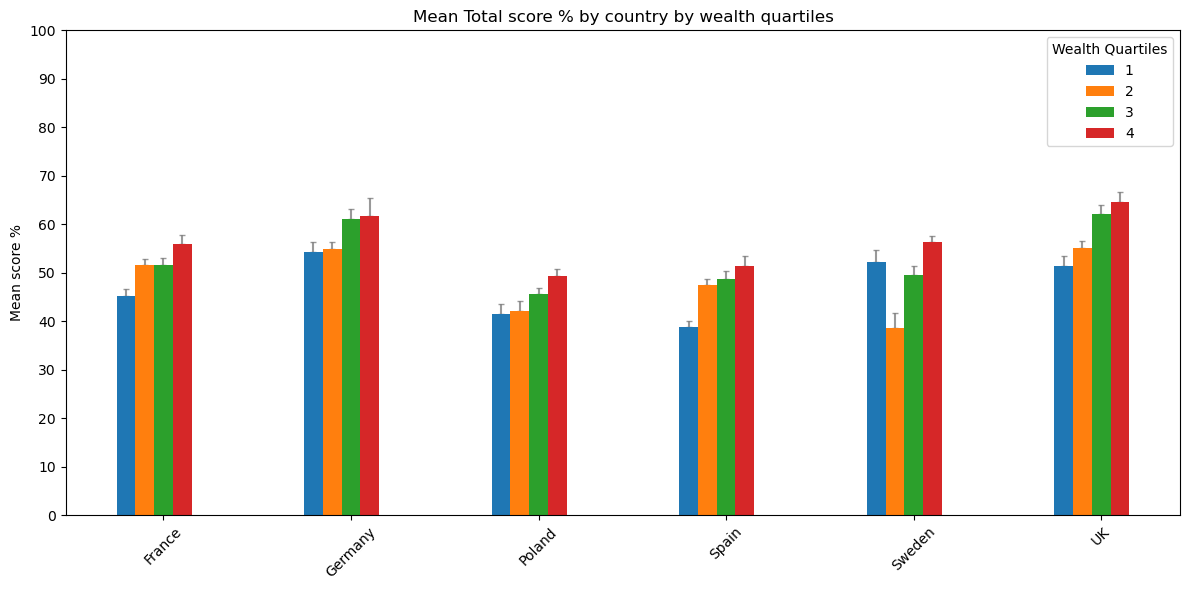

In [37]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])
sample = wealth_filtered_euro.copy()
wealth_quartiles = sorted(wealth_filtered_euro["wealth_quartile"].unique())


data_mean = sample.groupby(["country_text", "wealth_quartile"])["TotalScore_%"].mean().sort_index()
data_std = sample.groupby(["country_text", "wealth_quartile"])["TotalScore_%"].std().reindex(data_mean.index)
data_sem = sample.groupby(["country_text", "wealth_quartile"])["TotalScore_%"].sem().reindex(data_mean.index)

countries = sorted(sample["country_text"].unique())
x = np.arange(1, len(countries) + 1)
width = 0.1

for j, wealth_quartile in enumerate(wealth_quartiles):
    mean_facet_scores = data_mean.xs(key=wealth_quartile, level="wealth_quartile")
    sem_facet_scores = data_sem.xs(key=wealth_quartile, level="wealth_quartile")

    offset = (- len(wealth_quartiles)/ 2 + j) * width
    axes.bar(x + offset , mean_facet_scores, width, label = str(wealth_quartile))
    axes.errorbar(x + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(x)
axes.set_xticklabels(countries, rotation = 45, ha = "center")

axes.set_ylabel(f"Mean score %")
axes.set_title(f"Mean Total score % by country by wealth quartiles")
axes.legend(title="Wealth Quartiles", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()


---

## Table 4.2 - Per country per wealth quartile: M proportion of facet score + SD + Median

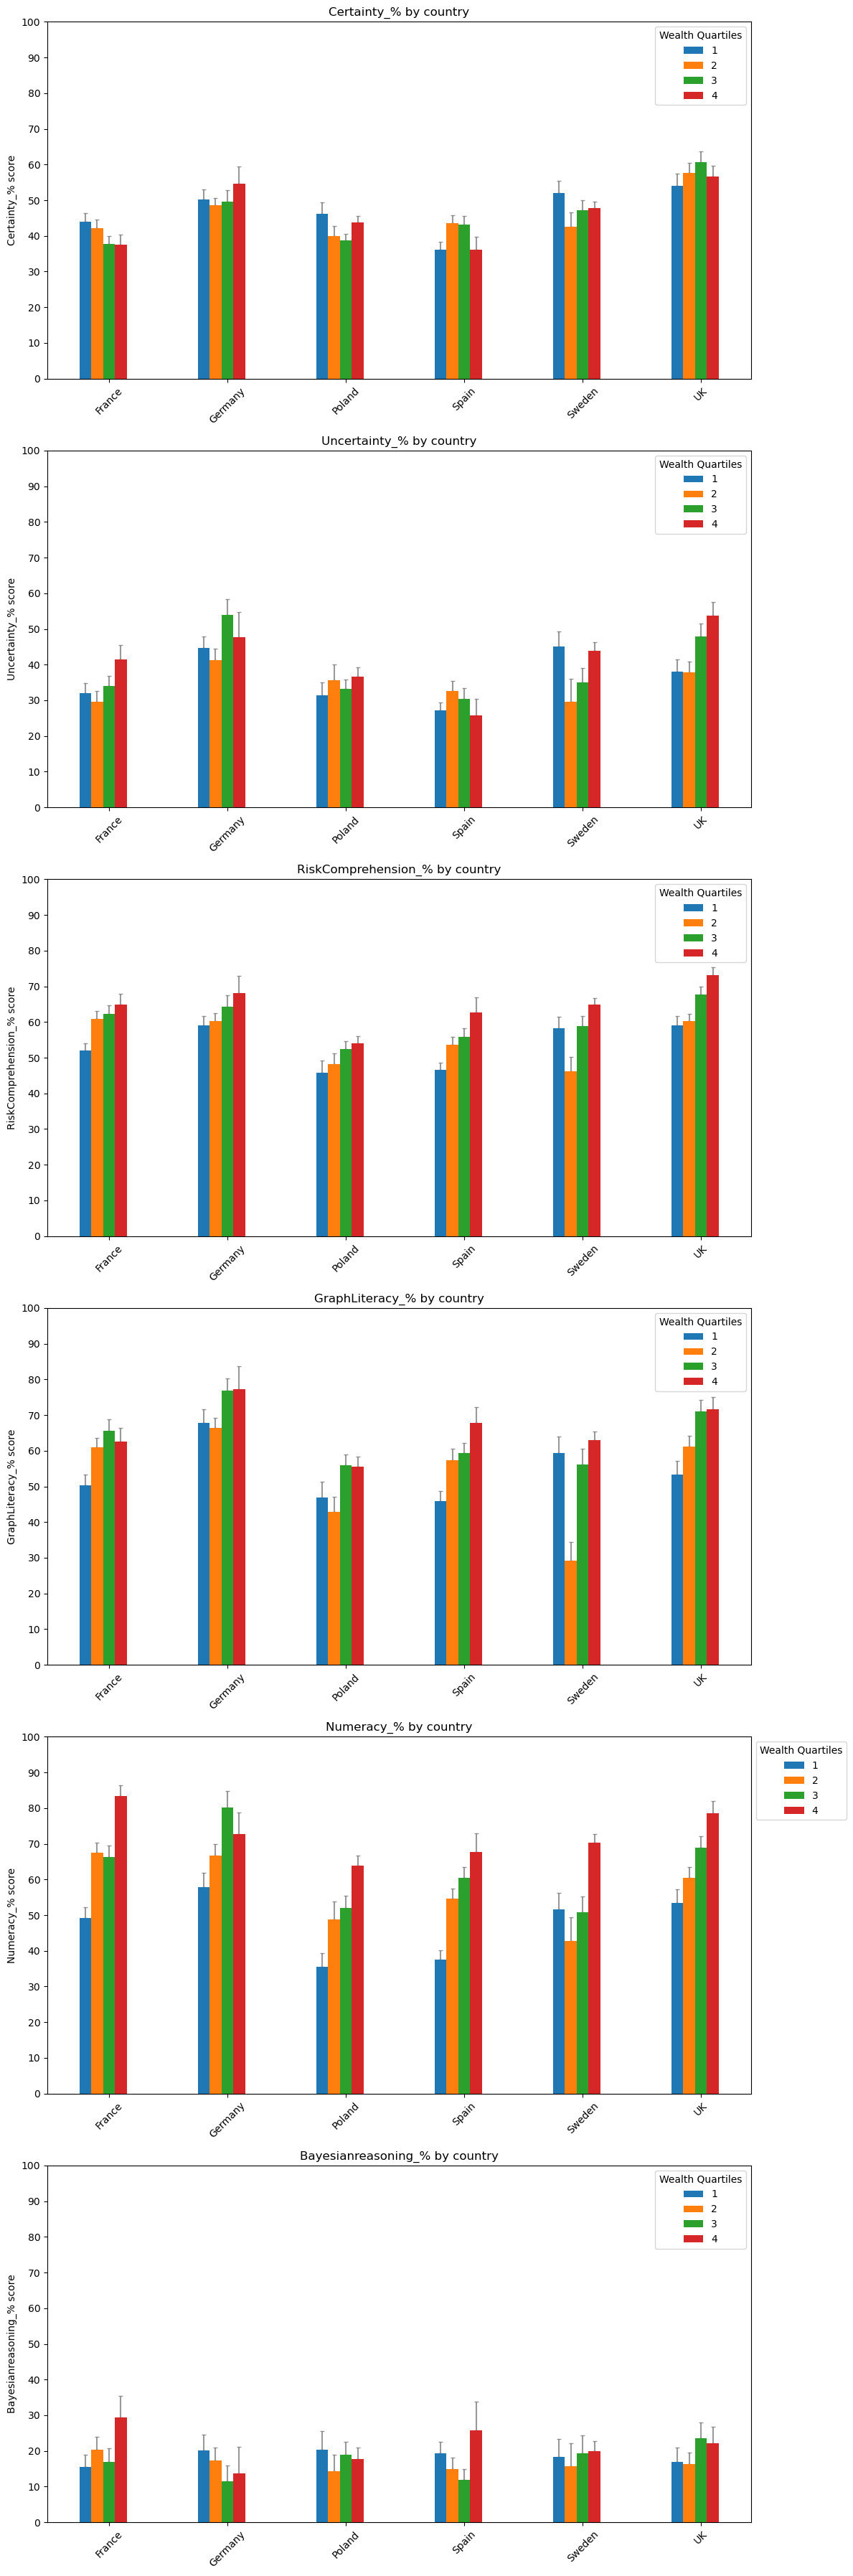

In [38]:
fig, axes = plt.subplots(6, 1, figsize = [12, 6*6])

axes = axes.flatten()
wealth_quartiles = sorted(wealth_filtered_euro["wealth_quartile"].unique())

for i, facet in enumerate(facet_percent_cols):

    sample = wealth_filtered_euro.loc[ :, [facet] + ["country_text", "wealth_quartile"]].copy().reset_index()
    
    data_mean = sample.groupby(["country_text", "wealth_quartile"])[facet].mean().sort_index()
    data_std = sample.groupby(["country_text", "wealth_quartile"])[facet].std().reindex(data_mean.index)
    data_sem = sample.groupby(["country_text", "wealth_quartile"])[facet].sem().reindex(data_mean.index)
    
    countries = sorted(sample["country_text"].unique())
    x = np.arange(1, len(countries) + 1)
    width = 0.1
    
    for j, wealth_quartile in enumerate(wealth_quartiles):
        mean_facet_scores = data_mean.xs(key=wealth_quartile, level="wealth_quartile")
        sem_facet_scores = data_sem.xs(key=wealth_quartile, level="wealth_quartile")
    
        offset = (- len(wealth_quartiles)/ 2 + j) * width
        axes[i].bar(x + offset , mean_facet_scores, width, label = str(wealth_quartile))
        axes[i].errorbar(x + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                      fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")

    
    axes[i].set_yticks(np.arange(0, 101, step = 10))
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(countries, rotation = 45, ha = "center")
    
    axes[i].set_ylabel(f"{facet} score")
    axes[i].set_title(f"{facet} by country")
    axes[i].legend(title="Wealth Quartiles", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()



---

---

## Table 5.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [39]:
wealth_filtered_euro = euro.loc[ ~(euro["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered_euro["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered_euro["wealth_quartile"] = wealth_quartile.copy()

In [40]:
wealth_filtered_euro = euro.loc[ ~(euro["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered_euro["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered_euro["wealth_quartile"] = wealth_quartile.copy()

risklit_quartile = pd.qcut(wealth_filtered_euro["TotalScore_19"],q = 4, labels = False ) + 1
wealth_filtered_euro["risklit_quartile"] = risklit_quartile.copy()

data = wealth_filtered_euro.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [41]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "wealth_quartile")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Wealth quartiles", bbox_to_anchor=(1, 1))
    
# plt.show()

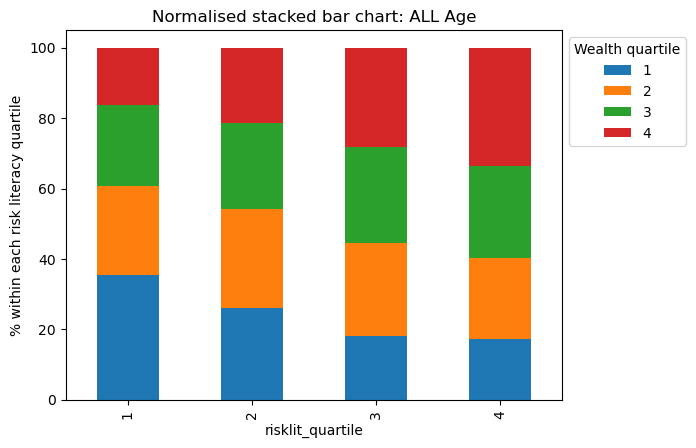

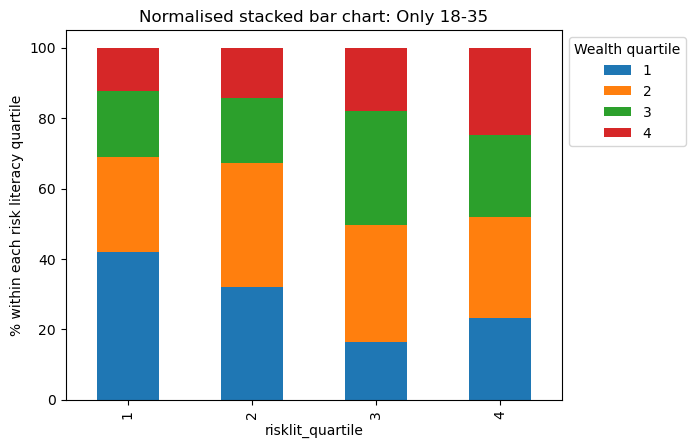

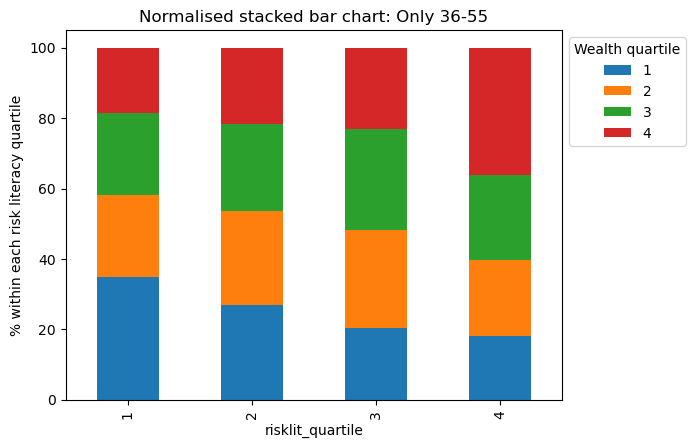

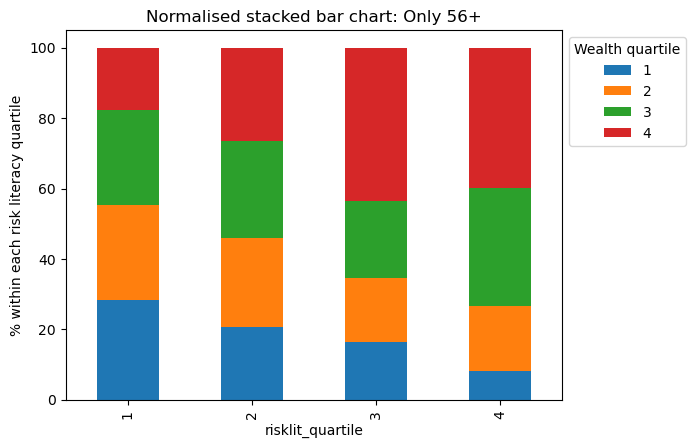

In [42]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "wealth_quartile")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Wealth quartile", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

In [43]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered_euro.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.008049
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -3398.1
Model:                   OrderedModel   AIC:                             6802.
Method:            Maximum Likelihood   BIC:                             6821.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:39                                         
No. Observations:                3371                                         
Df Residuals:                    3368                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

## Ordinal Logistic Regression (Proportional Odds Model) of Ordered Income Class depending on Risk literacy without, and with control of education, and with education and age

### V1: Without any control variables

In [44]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered_euro.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.688748
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -5692.8
Model:                   OrderedModel   AIC:                         1.140e+04
Method:            Maximum Likelihood   BIC:                         1.143e+04
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:39                                         
No. Observations:                3371                                         
Df Residuals:                    3365                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [45]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered_euro.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.661224
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -5600.0
Model:                   OrderedModel   AIC:                         1.121e+04
Method:            Maximum Likelihood   BIC:                         1.126e+04
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:39                                         
No. Observations:                3371                                         
Df Residuals:                    3364                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [46]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered_euro.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.660123
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -5596.3
Model:                   OrderedModel   AIC:                         1.121e+04
Method:            Maximum Likelihood   BIC:                         1.126e+04
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:40                                         
No. Observations:                3371                                         
Df Residuals:                    3363                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

---

## Ordinal Logistic Regression (Proportional Odds Model) of Ordered Income Class depending on Risk literacy without, and under control of education, FOR 36-55 years old, where we can assume skill-related variance

### V1: without control of education

In [47]:
data = income_filtered_euro.loc[income_filtered_euro["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.710521
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -2586.3
Model:                   OrderedModel   AIC:                             5185.
Method:            Maximum Likelihood   BIC:                             5217.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:40                                         
No. Observations:                1512                                         
Df Residuals:                    1506                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V1: with control of education

In [48]:
data = income_filtered_euro.loc[income_filtered_euro["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.674748
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -2532.2
Model:                   OrderedModel   AIC:                             5078.
Method:            Maximum Likelihood   BIC:                             5116.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:40                                         
No. Observations:                1512                                         
Df Residuals:                    1505                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

---

---

---

## Ordinal Logistic Regression (Proportional Odds Model) of Ordered Wealth Quartiles depending on Risk literacy without, and with control of education, and with education and age

### V1: Without any control variables

In [49]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered_euro.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.368199
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -2992.3
Model:                   OrderedModel   AIC:                             5993.
Method:            Maximum Likelihood   BIC:                             6015.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:40                                         
No. Observations:                2187                                         
Df Residuals:                    2183                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [50]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered_euro.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.349060
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -2950.4
Model:                   OrderedModel   AIC:                             5911.
Method:            Maximum Likelihood   BIC:                             5939.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:40                                         
No. Observations:                2187                                         
Df Residuals:                    2182                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [51]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered_euro.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.332683
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -2914.6
Model:                   OrderedModel   AIC:                             5841.
Method:            Maximum Likelihood   BIC:                             5875.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:40                                         
No. Observations:                2187                                         
Df Residuals:                    2181                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

---

## Ordinal Logistic Regression (Proportional Odds Model) of Ordered Wealth Quartiles depending on Risk literacy without, and under control of education, FOR 36-55 years old, where we can assume skill-related variance

### V1: without control of education

In [52]:
data = wealth_filtered_euro.loc[wealth_filtered_euro["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.372588
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -1313.6
Model:                   OrderedModel   AIC:                             2635.
Method:            Maximum Likelihood   BIC:                             2655.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:40                                         
No. Observations:                 957                                         
Df Residuals:                     953                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V1: with control of education

In [53]:
data = wealth_filtered_euro.loc[wealth_filtered_euro["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.337841
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -1280.3
Model:                   OrderedModel   AIC:                             2571.
Method:            Maximum Likelihood   BIC:                             2595.
Date:                Tue, 24 Jun 2025                                         
Time:                        15:03:40                                         
No. Observations:                 957                                         
Df Residuals:                     952                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------